## Introduction
In this notebook you will download and preprocess the data for the segmentation task for cardiac mri images:<br />
The data is provided by the medical segmentation decathlon (http://medicaldecathlon.com/)<br /> (Data License: https://creativecommons.org/licenses/by-sa/4.0/)<br />

You can directly download the cardiac MRIs and segmentation maps from: <br />
https://drive.google.com/file/d/1wEB2I6S6tQBVEPxir8cA5kFB8gTQadYY/view?usp=sharing

## Imports:
* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* tqdm for nice progressing bars

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

c:\Users\Flori\anaconda3\envs\udemy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Inspection:
Let's first inspect some sample data

In [2]:
root = Path("./Task01_BrainTumour/imagesTr/")
label = Path("./Task01_BrainTumour/labelsTr/")

We start with a helper function which automatically replaces "imagesTr" with "labelsTr" in the filepaths so that we can easily switch between mri images and label masks

In [3]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [4]:
sample_path = list(root.glob("BRATS*"))[10]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [5]:
sample_path, sample_path_label

(WindowsPath('Task01_BrainTumour/imagesTr/BRATS_011.nii.gz'),
 WindowsPath('Task01_BrainTumour/labelsTr/BRATS_011.nii.gz'))

Load NIfTI and extract image data

In [6]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata() #<class 'numpy.float64'>
mri = mri[..., 0] # # Just take the FLAIR channel (0)
mask = label.get_fdata().astype(np.uint8)  # Class labels should not be handled as float64
mask[mask >= 1] = 1 # orginal mask has different labels [0,1,2,3]. we change it to only 0 or 1

unique_values_mask = np.unique(mask)
print("Shape of mask: ",mask.shape)
print("Unique values in the mask:", unique_values_mask)

unique_values_mri = np.unique(mri)
max_value = np.max(mri)
min_nonzero_value = np.min(mask[mask != 0])

print("Shape of mri: ",mri.shape)
print("Maximum value in mri:", max_value)
print("Minimum value in mri taht is no 0:", min_nonzero_value)
print("Unique values in the array:", unique_values_mri)

Shape of mask:  (240, 240, 155)
Unique values in the mask: [0 1]
Shape of mri:  (240, 240, 155)
Maximum value in mri: 1689.0
Minimum value in mri taht is no 0: 1
Unique values in the array: [   0.    2.    4.    6.    8.   10.   12.   13.   15.   17.   19.   21.
   23.   25.   27.   29.   31.   33.   35.   36.   38.   40.   42.   44.
   46.   48.   50.   52.   54.   56.   58.   60.   61.   63.   65.   67.
   69.   71.   73.   75.   77.   79.   81.   83.   84.   86.   88.   90.
   92.   94.   96.   98.  100.  102.  104.  106.  107.  109.  111.  113.
  115.  117.  119.  121.  123.  125.  127.  129.  131.  132.  134.  136.
  138.  140.  142.  144.  146.  148.  150.  152.  154.  155.  157.  159.
  161.  163.  165.  167.  169.  171.  173.  175.  177.  179.  180.  182.
  184.  186.  188.  190.  192.  194.  196.  198.  200.  202.  203.  205.
  207.  209.  211.  213.  215.  217.  219.  221.  223.  225.  226.  228.
  230.  232.  234.  236.  238.  240.  242.  244.  246.  248.  250.  251.
  253. 

In [7]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

Let's inspect the data.
We use the sagittal view for this task as it provides the "nicest" images<br />

We can use celluloid (https://github.com/jwkvam/celluloid) which is a great tool for live visualization in matplotlib.<br />
Additionally we import HTML from IPython.display to create a video of the volume.

In [8]:
### from celluloid import Camera
from celluloid import Camera
from IPython.display import HTML

In [9]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

# Calculate the intensity range of the MRI data


for i in range(mri.shape[2]):  # Transverse view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation


<IPython.core.display.Javascript object>

In [10]:
HTML(animation.to_html5_video())  # convert the animation to a video


c:\Users\Flori\anaconda3\envs\udemy\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\Users\Flori\anaconda3\envs\udemy\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


## Preprocessing
We perform the following preprocessing steps:

1. Normalization per subject. We compute mean and sigma of the full 3d volume $X$ and then perform z-normalization:
$$X_n = \frac{X-\mu}{\sigma}$$
2. There is a plenty of empty space around the image, so we can crop the image (e.g 32 px from top and bottom). Additionally, we can crop away non-cardiac regions as they will definitely not contain the left atrium. This will  reduce training time due to the smaller size and will simplify the segmentation. It is important to crop first and to normalize afterwards. Otherwise the included zero values introduce skewness to the intesity distribution.
3. Standardize the normalized subject into the 0-1 range:
$$X_s = \frac{X_n - min(X_n)}{max(X_n)-min(X_n)} $$
4. This task will be performed on a slice level (2D) and not on a subject level (3D). In order to reduce the computational cost we store the preprocessed data as npy files of 2d slices. Reading a single slice is much faster than loading the complete NIfTI file every time.

In [11]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


Now we can loop over the subjects and store the preprocessed files in the corresponding directories.
To evaluate our model we use the last 4 subjects as validation set.

We want to create a directory containing a numpy file for each slice of the MRI image and the associated label mask of each subject.
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [13]:
all_files = list(root.glob("BRA*"))  # Get all subjects
len(all_files)

484

In [15]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_mri_data)
    
    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")    
    mri_data = mri.get_fdata()
    mri_data = mri_data[..., 0] # For now Just take the FLAIR channel (0) <-- Flo edit

    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
    
    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    #mri_data = mri_data[32:-32, 32:-32]
    #label_data = label_data[32:-32, 32:-32]
    
    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)
    
    # Check if train or val data and create corresponding path
    if counter < 450:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        mask[mask >= 1] = 1 # orginal mask has different labels [0,1,2,3]. we change it to only 0 or 1
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

  0%|          | 0/484 [00:00<?, ?it/s]

## Validate preprocessed data
Now, we can take a look at the stored files and inspect if everything works

In [45]:
path = Path("Preprocessed/train/7/")  # Select a subject


In [46]:
# Choose a file and load slice + mask
file = "85.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)
unique_values_mask = np.unique(mask)
print("Shape of mask: ",mask.shape)
print("Unique values in the mask:", unique_values_mask)

Shape of mask:  (240, 240)
Unique values in the mask: [0 1]


<IPython.core.display.Javascript object>


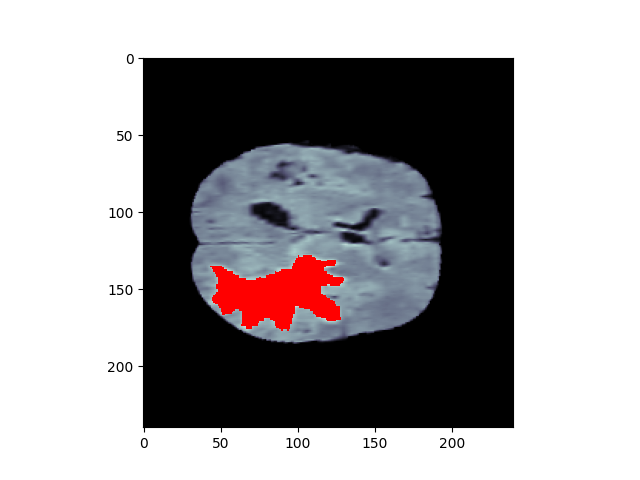

In [47]:
# Plot everything
plt.figure()
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap="autumn")

In [31]:
print(slice.min(), slice.max())

0.0 0.9131064446053585
